This notebook simulates scopes for the amide datasets using BO-based methods and analyzed them.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Code.benchmark import Benchmark
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys


# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)
wdir = Path(".")


# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
    })

In [2]:
datasets = ["high","medium","low"]

### Calculate the normalization bounds

In [3]:
# # run scopes to get the bounds
# for dset in datasets:
#     Benchmark().collect_data(
#         filename_labelled = f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",  
#         name_results = f"./Results_Data/Bounds/40greedy-{dset}", objectives=['yield'], 
#         budget = 40, batches= [1,2,3,4], Vendi_pruning_fractions = [0], seeds = 40, 
#         acquisition_function_mode= "greedy", pruning_metric= "vendi_batch", init_sampling_method="random")

#     # most extreme vendi pruning for a scope of 40 samples for the different batch sizes
#     extreme_pruning_40 = {1: 8, 2: 17, 3: 25, 4: 33}
#     # Run the scopes
#     for batch in extreme_pruning_40:
#         Benchmark().collect_data(
#             filename_labelled = f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",  
#             name_results = f"./Results_Data/Bounds/40explorative-{dset}/40explorative_b{batch}", objectives=['yield'], 
#             budget = 40, batches= [batch], Vendi_pruning_fractions = [extreme_pruning_40[batch]], 
#             seeds = 40, acquisition_function_mode= "explorative", pruning_metric= "vendi_batch", init_sampling_method="random")

In [19]:
# create a dataframe to save the normalization bounds
df_bounds = pd.DataFrame(np.nan,index=["obj_min","obj_max","vendi_min","vendi_max"],columns= datasets)
# Get the data
for dset in datasets:
    vendi_explore_max_40 = []
    for batch in [1,2,3,4]:
        df_explore_max_40 = Benchmark().heatmap_plot(type_results="vendi",
                                                     name_results=f"./Results_Data/Bounds/40explorative-{dset}"\
                                                        f"/40explorative_b{batch}",
                                                     budget=40,show_plot=False)
        vendi_explore_max_40.append(df_explore_max_40.max().max())  # recording the highest Vendi score for this scope
    df_bounds.loc["vendi_max",dset] = max(vendi_explore_max_40)
    
    obj_explore_max_40 = []
    for batch in [1,2,3,4]:
        df_explore_max_40 = Benchmark().heatmap_plot(type_results="objective",
                                                     name_results=f"./Results_Data/Bounds/40explorative-{dset}"\
                                                        f"/40explorative_b{batch}",
                                                     budget=40,show_plot=False)
        obj_explore_max_40.append(df_explore_max_40.min().min())  # recording the lowest average objective for this scope
    df_bounds.loc["obj_min",dset]  = min(obj_explore_max_40)
    
    df_greedy_40_vendi = Benchmark().heatmap_plot(type_results="vendi",name_results=f"./Results_Data/Bounds"\
                                                  f"/40greedy-{dset}",budget=40,show_plot=False)
    df_bounds.loc["vendi_min",dset] = df_greedy_40_vendi.min().min()
    
    df_greedy_40_obj = Benchmark().heatmap_plot(type_results="objective",name_results=f"./Results_Data/Bounds"\
                                                f"/40greedy-{dset}",budget=40,show_plot=False)
    df_bounds.loc["obj_max",dset] = df_greedy_40_obj.max().max()

# save the bounds in a file
df_bounds.to_csv("./../Amide_data/Datasets/bounds_subs.csv",index=True,header=True)
print("Normalization bounds:")
df_bounds

Normalization bounds:


,high,medium,low
obj_min,0.524635,0.344322,0.152959
obj_max,0.705849,0.441517,0.347364
vendi_min,2.889390,2.903768,2.895324
vendi_max,9.740334,9.731709,9.770858


In [5]:
# define a function to extract the relevant bounds in a format suitable for the Benchmark class
def get_bounds(dset):
    bounds = {}
    # get the metrics for the rate objective
    bounds["yield"] = (df_bounds.loc["obj_max",dset],df_bounds.loc["obj_min",dset])
    # get the metrics for the vendi score
    bounds["vendi"] = (df_bounds.loc["vendi_max",dset],df_bounds.loc["vendi_min",dset])

    return bounds

### Scope runs

Run scopes for BO-based methods with each dataset using the optimized hyperparametrs of ScopeBO and also the same conditions without the Vendi pruning.

In [6]:
# for dset in datasets:
#     for acq in ["ei","random-selection","greedy","explorative"]:
#         if acq == "ei":
#             acq_label = "balanced"
#         elif acq == "random-selection":
#             acq_label = "random"
#         else:
#             acq_label = acq
#         for pruning in [False,True]:
#             if pruning:
#                 pruning_label = "with-pruning"
#                 pruning_fraction = 13
#             else:
#                 pruning_label = "no-pruning"
#                 pruning_fraction = 0
#             Benchmark().collect_data(
#                 filename_labelled = f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",
#                 name_results = f"./Results_Data/{dset}-dataset/{acq}_{pruning_label}",
#                 objectives=['yield'],
#                 budget = 27,
#                 batches= [3],
#                 Vendi_pruning_fractions = [pruning_fraction],
#                 seeds = 40,
#                 acquisition_function_mode= acq_label,
#                 pruning_metric= "vendi_batch",
#                 init_sampling_method="random"
#                 )

Generate scopes with settings similar to how humans would select a scope (greedy, 5% Vendi pruning per batch)

In [7]:
# for dset in datasets:
#     Benchmark().collect_data(
#         filename_labelled = f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",
#         name_results = f"./Results_Data/{dset}-dataset/human-like-acq",
#         objectives=['yield'],
#         budget = 27,
#         batches= [3],
#         Vendi_pruning_fractions = [5],
#         seeds = 40,
#         acquisition_function_mode= "greedy",
#         pruning_metric= "vendi_batch",
#         init_sampling_method="random"
#         )

Fetch the results

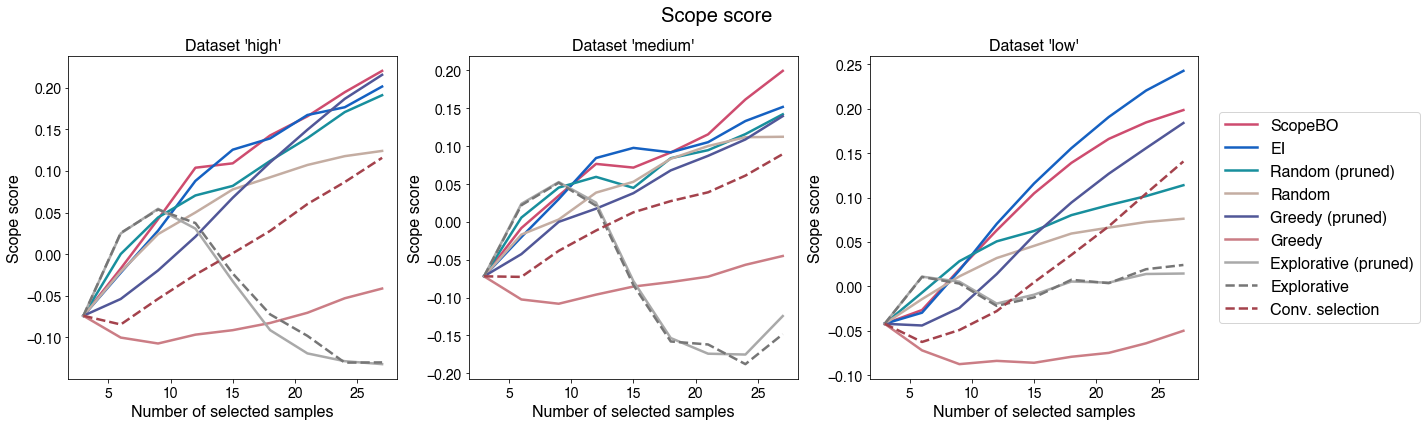

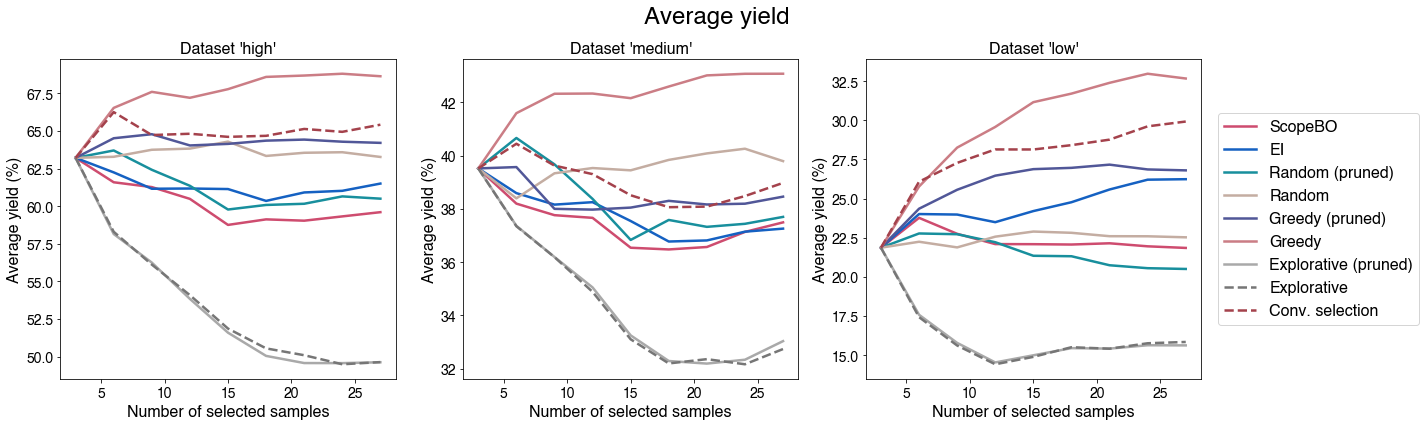

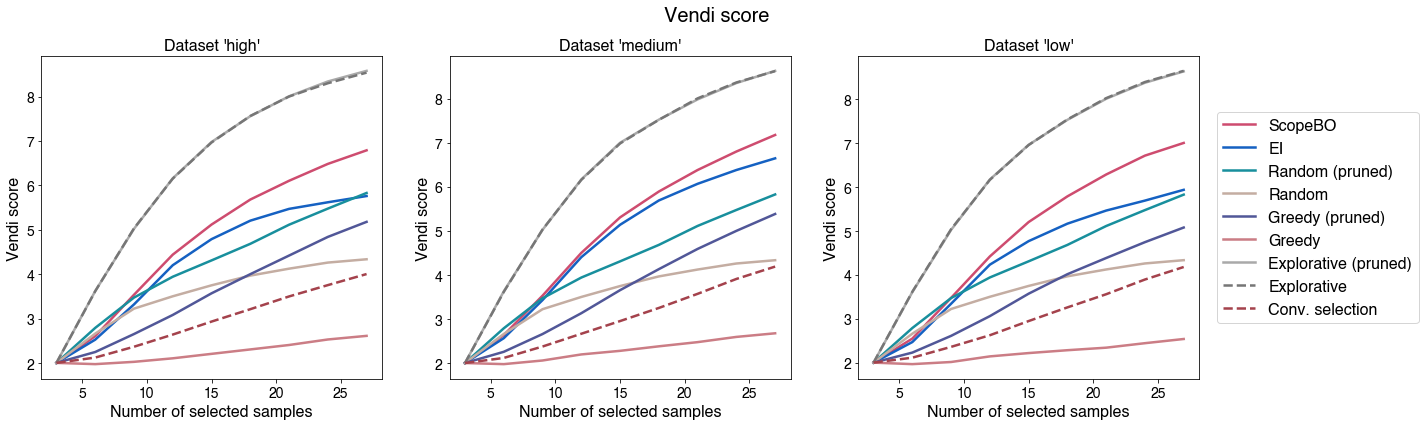

In [8]:
dfs_results = {}
def score_overview(metrics):
    for type_results in metrics:
        # Initialize the figure
        fig, axes = plt.subplots(1,4,figsize=(20,6), gridspec_kw={'width_ratios': [1, 1, 1, 0.3]})
        if type_results == "Yield":
            fig.suptitle("Average yield")
        else:
            fig.suptitle(f"{type_results} score",fontsize=20)
        # Go through the datasets
        for i,dset in enumerate(datasets):
            dfs = {}
            # Get the data for all acquisition functions
            for acq in ["EI","Random","Greedy","Explorative","Conv. selection"]:
                if acq.lower() == "random":
                    acq_label = "random-selection"
                elif acq == "Conv. selection":
                    acq_label = "human-like-acq"
                else:
                    acq_label = acq.lower()
                for pruning in [True,False]:
                    if pruning:
                        pruning_label = "_with-pruning"
                    else:
                        pruning_label = "_no-pruning"
                    if acq == "Conv. selection":
                        pruning_label = ""
                    dfs_progress = Benchmark().progress_plot(budget=27, type_results= type_results,
                                            name_results=f"Results_Data/{dset}-dataset"\
                                                f"/{acq_label}{pruning_label}",
                                            bounds=get_bounds(dset),show_plot=False)
                    if type_results.lower() == "yield":
                        dfs_progress["means"] = dfs_progress["means"].applymap(lambda x: x*100)  # scale yields from [0,1] to [0,100]
                    dfs[acq+pruning_label] = dfs_progress["means"]
            # Combine the results and plot them
            df_combined = pd.concat(dfs,axis=1)
            df_combined.columns = [multiindex[0] for multiindex in df_combined.columns]
            df_combined.rename(columns={"EI_with-pruning":"ScopeBO"},inplace=True)
            df_combined = df_combined[["ScopeBO"] + [col for col in df_combined.columns if col != "ScopeBO"]]
            label_dict = {col: col for col in df_combined.columns}
            for key,val in label_dict.items():
                if "_no-pruning" in val:
                    label_dict[key] = val.split("_")[0]
                elif "with-pruning" in val:
                    label_dict[key] = val.split("_")[0] + " (pruned)"
            df_combined.rename(columns=label_dict,inplace=True)
            dfs_results[f"{dset}_{type_results}"] = df_combined
            for j,col in enumerate(df_combined.columns):
                style = '-' if j <= 6 else '--' if j <= 13 else ':'
                plotting = df_combined[col][df_combined[col].notna()]
                axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], 
                             linestyle=style, linewidth=2.5)
            # Collect the labels for the legend
            if i == 0:
                handles_collected, labels_collected = axes[i].get_legend_handles_labels()
            axes[i].set_xlabel('Number of selected samples',fontsize=16)
            if type_results == "Yield":
                axes[i].set_ylabel(f"Average yield (%)",fontsize=16)
            else:
                axes[i].set_ylabel(f"{type_results} score",fontsize=16)
            axes[i].set_title(f"Dataset '{dset}'",fontsize=16)
            # Last subplot is used for the shared legend
            axes[3].axis('off')
            axes[3].legend(handles=handles_collected, labels=labels_collected,
                        fontsize=16, loc='center')
            
        plt.tight_layout()
        plt.show()

dfs = score_overview(["Scope","Yield","Vendi"])

Summarize the results

In [9]:
final_scopes = {}
natural_scores = {}
# get the final metric for the datasets
for dset in datasets:
    final_scope = pd.DataFrame(np.nan, index = ["Scope","Yield","Vendi"], columns = dfs_results["high_Scope"].columns)
    for idx in final_scope.index:
        for col in final_scope.columns:
            final_scope.loc[idx,col] = dfs_results[f"{dset}_{idx}"][col].iloc[-1]
    final_scope = final_scope[["Greedy","Greedy (pruned)", "EI","ScopeBO","Random",
                               "Random (pruned)","Explorative","Explorative (pruned)", "Conv. selection"]]
    # Normalize each metric
    natural_scores[dset] = final_scope
    final_scope = final_scope.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    final_scopes[dset] = final_scope

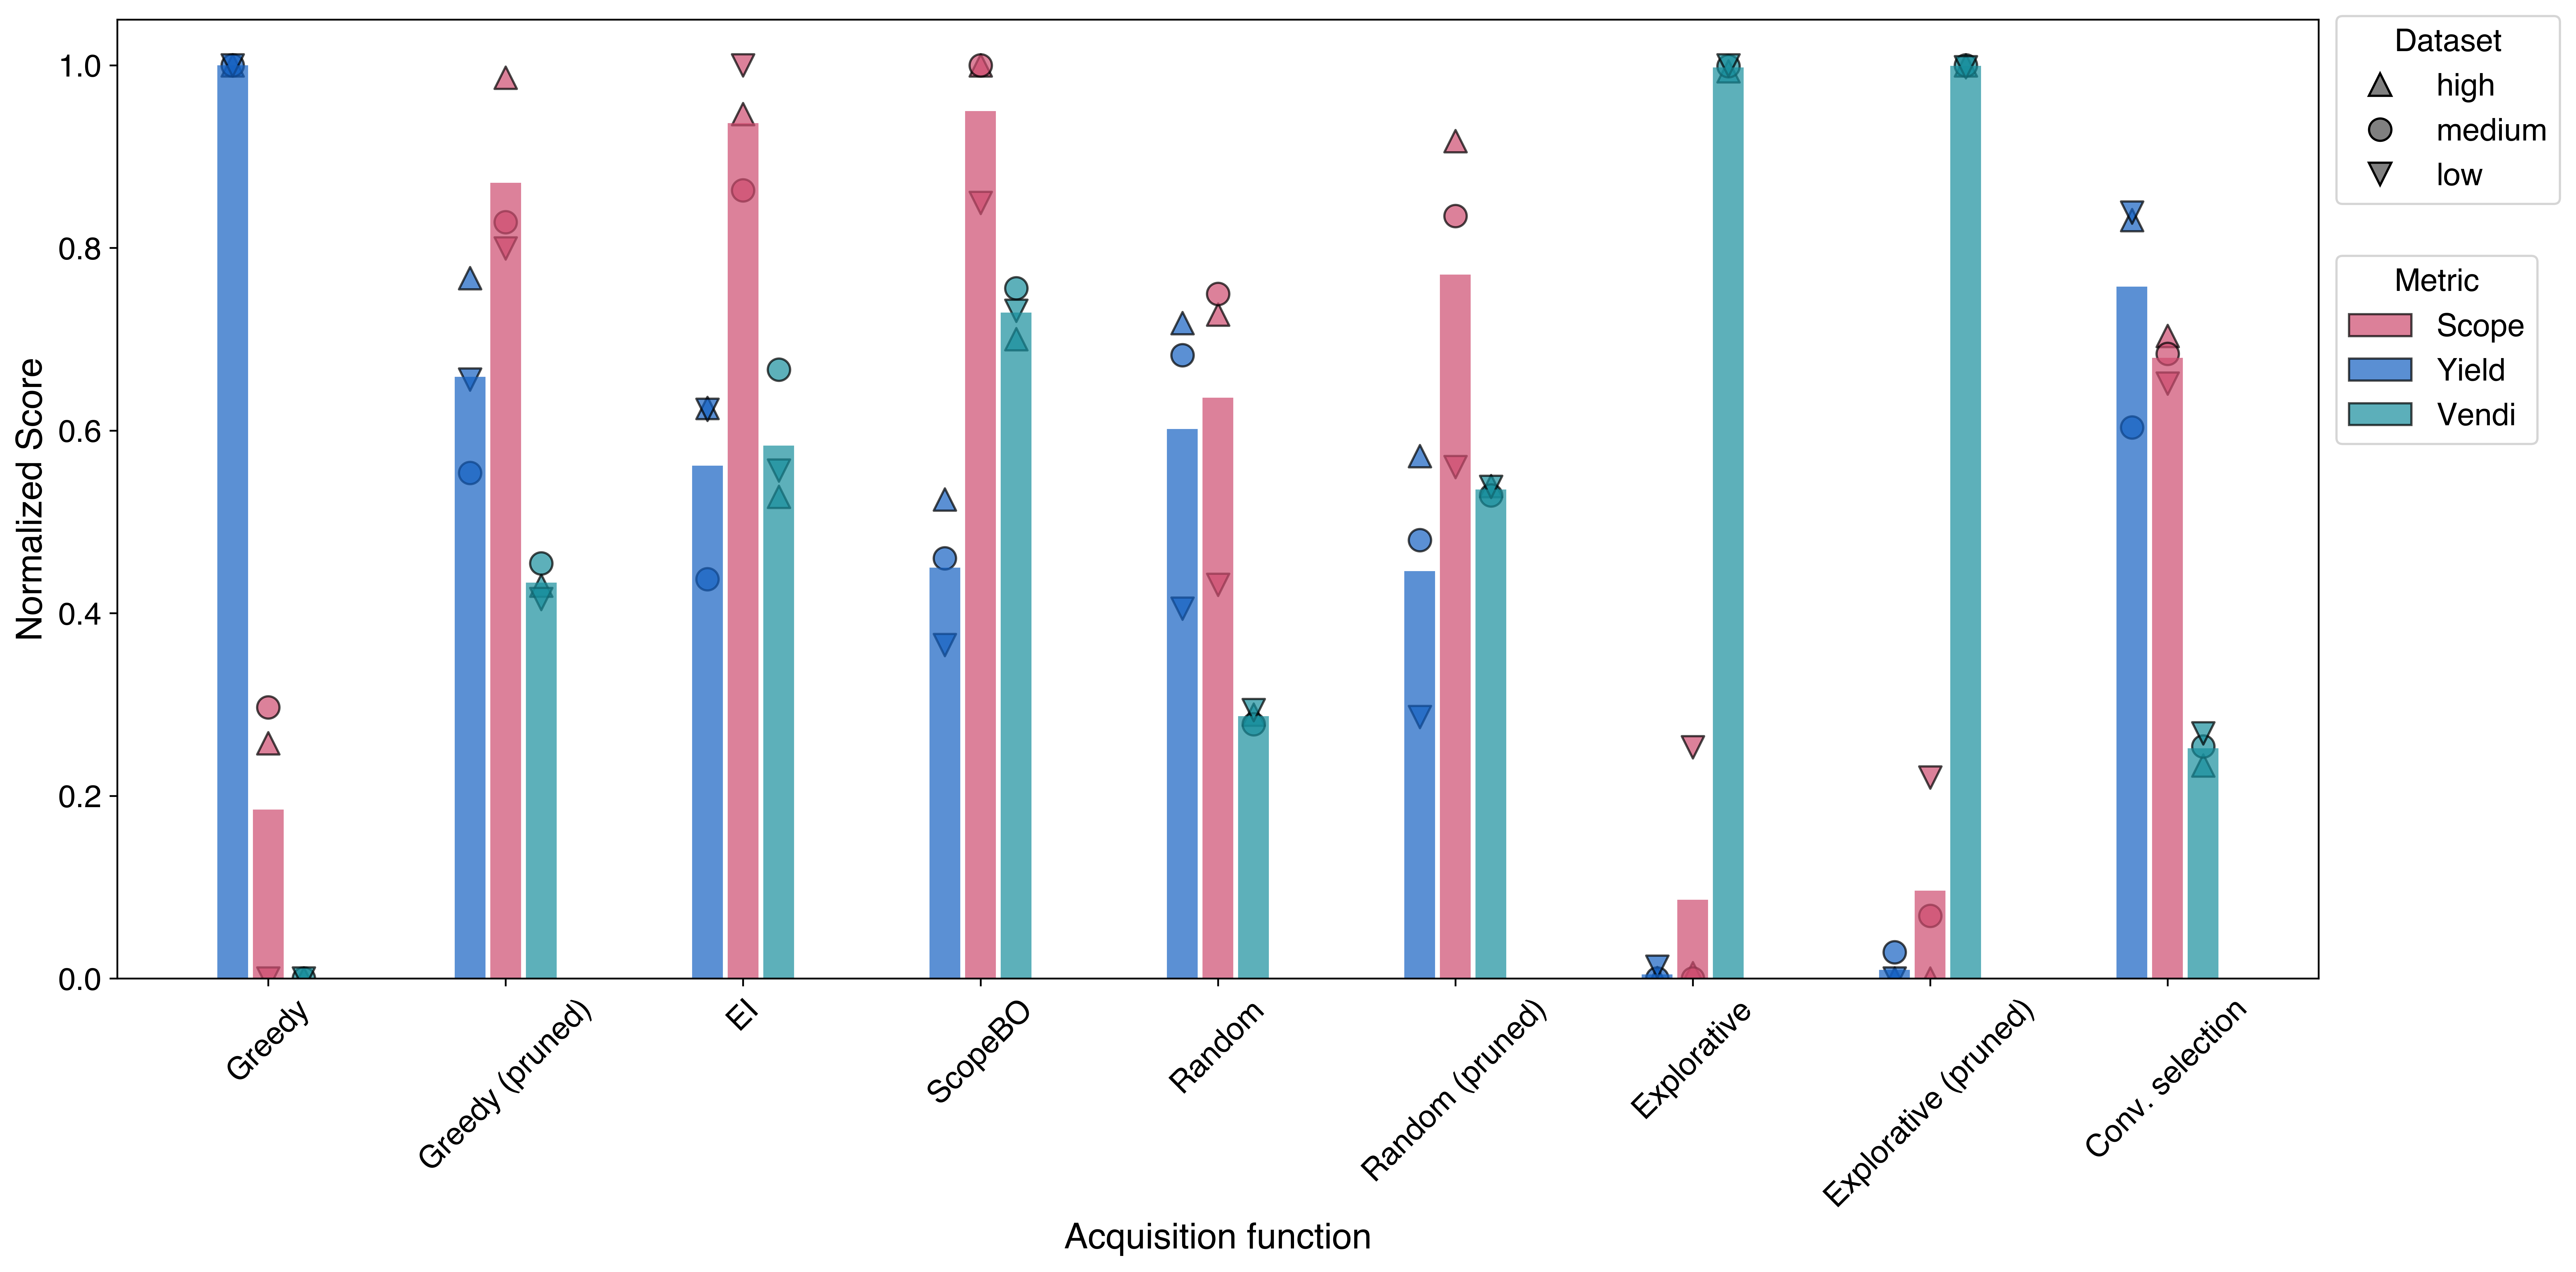

In [10]:
# make a summary plot

records = []
for dataset_name, df in final_scopes.items():
    for idx in df.index:
        for metric in df.columns:
            records.append({
                'Dataset': dataset_name,
                "Acq. Fct.": metric,
                "Metric": idx,
                'Score': df.loc[idx, metric]
            })

long_df = pd.DataFrame(records)
shift = 0.15
offsets = {'Scope': 0, 'Yield': -shift, 'Vendi': shift}
long_df['XOffset'] = long_df["Metric"].map(offsets)

# Positions for each metric
metrics = list(final_scopes["high"].columns)
x_pos_map = {metric: i for i, metric in enumerate(metrics)}
long_df['XBase'] = long_df["Acq. Fct."].map(x_pos_map)
long_df['X'] = long_df['XBase'] + long_df['XOffset']

# Plotting
plt.figure(figsize=(16, 8),dpi=600)
markers = {'high': '^', 'medium': 'o', 'low': 'v'}
colors = {'Scope': all_colors[0], 'Yield': all_colors[1], 'Vendi': all_colors[2]}

# Plot each combination of metric and dataset
for dataset in final_scopes.keys():
    for idx in final_scopes["high"].index:
        subset = long_df[(long_df['Dataset'] == dataset) & (long_df["Metric"] == idx)]
        plt.scatter(
            subset['X'], 
            subset['Score'], 
            marker=markers[dataset],
            color=colors[idx],
            s=100,
            edgecolor='k',
            linewidths=1,
            alpha=0.7
        )

# Legend for Dataset (marker)
dataset_legend = [
    Line2D([0], [0], marker=markers[name], color='w', label=name,
           markerfacecolor='gray', markeredgecolor='k', markersize=10)
    for name in markers
]

# Legend for metric (color)
index_legend = [
    Patch(facecolor=colors[name], edgecolor='k', label=name, alpha = 0.7)
    for name in colors
]

# Add the legends
legend1 = plt.legend(handles=dataset_legend, title='Dataset', loc='upper left', bbox_to_anchor=(1.001, 1.02))
legend2 = plt.legend(handles=index_legend, title='Metric', loc='upper left', bbox_to_anchor=(1.001, 0.77))

plt.gca().add_artist(legend1)
plt.xticks(ticks=range(len(metrics)), labels=metrics,rotation=45)
plt.ylabel('Normalized Score')
plt.xlabel("Acquisition function")

# calculate the averages
avg_scores = (
    long_df
    .groupby(["Acq. Fct.", "Metric"], as_index=False)['Score']
    .mean()
)

# map the averages to the plot locations
avg_scores['XBase'] = avg_scores["Acq. Fct."].map(x_pos_map)
avg_scores['XOffset'] = avg_scores["Metric"].map(offsets)
avg_scores['X'] = avg_scores['XBase'] + avg_scores['XOffset']

# bar plot for the averages
bar_width = 0.13
for idx, color in colors.items():
    subset = avg_scores[avg_scores["Metric"] == idx]
    plt.bar(
        subset['X'], 
        subset['Score'], 
        width=bar_width, 
        color=color, 
        alpha=0.7, 
        label=f'{idx} avg'
    )

plt.tight_layout()
plt.show()

In [11]:
print("Averaged normalized scope scores:")
avg_scores.sort_values(by="Score",inplace=True,ascending=False)
avg_scores.loc[avg_scores["Metric"]=="Scope"][["Acq. Fct.","Score"]]

Averaged normalized scope scores:


,Acq. Fct.,Score
24,ScopeBO,0.949728
3,EI,0.936497
15,Greedy (pruned),0.871341
21,Random (pruned),0.770716
0,Conv. selection,0.679651
18,Random,0.635929
12,Greedy,0.184882
9,Explorative (pruned),0.096350
6,Explorative,0.086374


Visualize another way

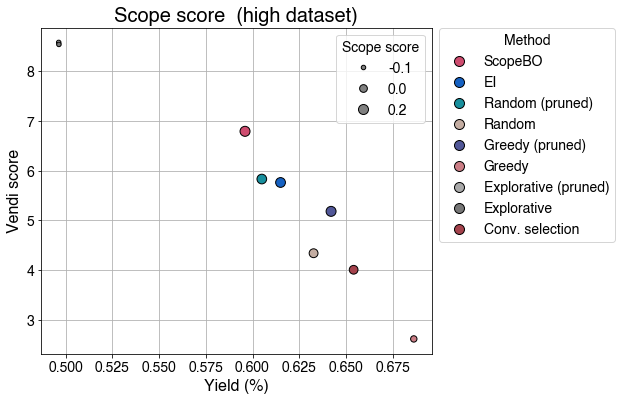

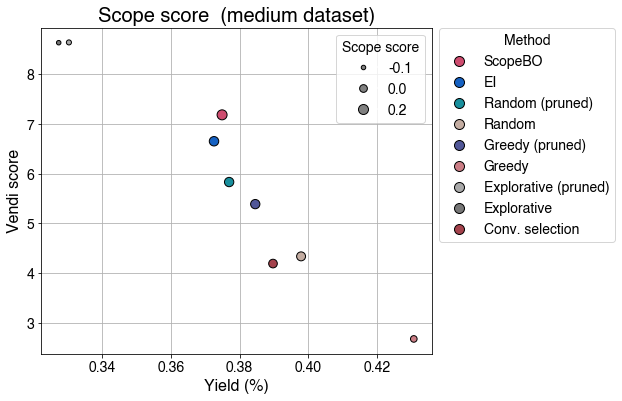

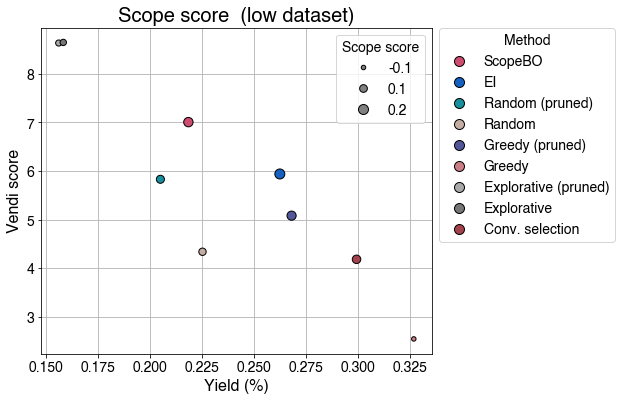

In [12]:
acq_fct = ["EI","Random","Greedy","Explorative", "Conv. selection"]
pruning_opt = [False,True]
datasets = ["high","medium","low"]

for dset in datasets:
    # collect the data for the different acquisition functions
    map_data = {}
    for acq in acq_fct:
        if acq.lower() == "random":
            acq_label = "random-selection"
        elif acq == "Conv. selection":
            acq_label = "human-like-acq"
        else:
            acq_label = acq.lower()
        for pruning in [True,False]:
            if pruning:
                pruning_label = "_with-pruning"
            else:
                pruning_label = "_no-pruning"
            if acq == "Conv. selection":
                pruning_label = ""
            run_results = []
            for type_results in ["Objective","Vendi","Scope"]:
                dfs_scaled,_ = Benchmark.get_metric_overview(budget=27,type_results=type_results,
                                              name_results=f"Results_Data/{dset}-dataset/{acq_label}{pruning_label}",
                                              scope_method="product", objective_weights=None,
                                              bounds = get_bounds(dset), directory=".")
                run_results.append(dfs_scaled["means"].iloc[-1,0])  # save the last mean which is the result at the end of the scope
            map_data[f"{acq}{pruning_label}"] = run_results
    map_df = pd.DataFrame.from_dict(map_data)
    map_df.rename(columns={"EI_with-pruning":"ScopeBO"},inplace=True)
    map_df = map_df[["ScopeBO"] + [col for col in map_df.columns if col != "ScopeBO"]]
    label_dict = {col: col for col in map_df.columns}
    for key,val in label_dict.items():
        if "_no-pruning" in val:
            label_dict[key] = val.split("_")[0]
        elif "with-pruning" in val:
            label_dict[key] = val.split("_")[0] + " (pruned)"
    map_df.rename(columns=label_dict,inplace=True)

    # prepare the data for plotting
    x = map_df.iloc[0]
    y = map_df.iloc[1]
    raw_size_data = map_df.iloc[2]
    labels = map_df.columns
    
    size_min, size_max = 20, 100
    data_min, data_max= raw_size_data.min(), raw_size_data.max()
    sizes = size_min + (raw_size_data - data_min) * (size_max - size_min) / (data_max - data_min)

    color_map = {label: all_colors[i] for i, label in enumerate(labels)}
    colors = [color_map[label] for label in labels]
    alpha_val = 1

    # plot the data
    plt.figure(figsize=(7,6))
    plt.title(f"Performance map ({dset} dataset)")
    plt.scatter(x, y, s=sizes, alpha=alpha_val, c = colors, edgecolors="k", zorder=2)
    plt.xlabel('Yield (%)')
    plt.ylabel('Vendi score')
    plt.title(f'Scope score  ({dset} dataset)')
    plt.grid(True, zorder=1)

    # legend for the method (color)
    color_legend = [
        Line2D(
            [0], [0],
            marker='o',
            color='w',
            label=label,
            markerfacecolor=color_map[label],
            alpha=alpha_val,
            markeredgecolor='k',
            markersize=10
        )
        for label in labels
    ]

    # legend for the scope score (size)
    # Choose representative raw size values
    size_legend_values = np.linspace(raw_size_data.min(), raw_size_data.max(), 3)
    size_legend_sizes = size_min + (size_legend_values - data_min) * (size_max - size_min) / (data_max - data_min)
    size_legend = [
        Line2D(
            [0], [0],
            marker='o',
            color='w',
            label=f'{val:.1f}',
            markerfacecolor='gray',
            alpha=alpha_val,
            markeredgecolor='k',
            markersize=np.sqrt(s)  # matplotlib sizes are in area, markersize is radius
        )
        for val, s in zip(size_legend_values, size_legend_sizes)
    ]

    # Add legends
    first_legend = plt.legend(handles=color_legend, loc = "upper left", title="Method", 
                              frameon=True, bbox_to_anchor=(1.001, 1.02))
    plt.gca().add_artist(first_legend)  # Add first legend manually
    second_legend = plt.legend(handles=size_legend, title=f"Scope score", frameon=True)

    plt.show()


Print the final metrics for all datasets

In [13]:
print("High dataset:")
natural_scores["high"].T.applymap(lambda x: round(x,3))

High dataset:


,Scope,Yield,Vendi
Greedy,-0.041,68.635,2.614
Greedy (pruned),0.215,64.205,5.180
EI,0.201,61.500,5.761
ScopeBO,0.220,59.598,6.790
Random,0.124,63.269,4.338
Random (pruned),0.191,60.496,5.830
Explorative,-0.130,49.631,8.539
Explorative (pruned),-0.132,49.620,8.578
Conv. selection,0.116,65.413,4.005


In [14]:
print("Medium dataset:")
natural_scores["medium"].T.applymap(lambda x: round(x,3))

Medium dataset:


,Scope,Yield,Vendi
Greedy,-0.045,43.073,2.680
Greedy (pruned),0.140,38.456,5.387
EI,0.152,37.255,6.649
ScopeBO,0.199,37.490,7.179
Random,0.112,39.791,4.338
Random (pruned),0.142,37.696,5.830
Explorative,-0.148,32.733,8.628
Explorative (pruned),-0.124,33.030,8.634
Conv. selection,0.090,38.973,4.193


In [15]:
print("Low dataset:")
natural_scores["low"].T.applymap(lambda x: round(x,3))

Low dataset:


,Scope,Yield,Vendi
Greedy,-0.050,32.668,2.543
Greedy (pruned),0.184,26.800,5.081
EI,0.243,26.236,5.940
ScopeBO,0.198,21.846,7.007
Random,0.076,22.524,4.338
Random (pruned),0.114,20.502,5.830
Explorative,0.024,15.840,8.648
Explorative (pruned),0.014,15.620,8.636
Conv. selection,0.141,29.919,4.182


ScopeBO shows the best overall scope score and also the highest score in 2 of the 3 datasets. It is closely followed by EI which achives higher average yields, but lower sample diversity, highlighting the difference in tradeoff between the two performance metrics.

As all datasets contain the same substrates and only differ in the yield labels, we can compare the Vendi scores between the  datasets. They are fairly consistent showing that the yield distribution does not significantly influence the diversity of the selected substrates. In contrast, the average yield is approximately mirrowing the average of the full dataset, illustrating that this metric is strongly dependent on the dataset.